# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<div class="alert alert-block alert-info">
    <h2>Содержание</h2>
    <h3>Шаг 1.<a href='#session1'>Общая информация</a></h3>
    <h3>Шаг 2. Предоработка данных</h3>
    <h4>Шаг 2.1 <a href=#session2>Определение и изучение пропущенных значений</a></h4>
    <h4>Шаг 2.2 <a href=#session3>Приведение типов</a></h4>
    <h3>Шаг 3. <a href='#session4'>Добавление данных в таблицу</a></h3>
    <h3>Шаг 4. <a href='#session5'>Исследовательский анализ данных</a></h3>
    <h4>Шаг 4.1 <a href=#session7>Изучение времени продажи квартиры</a></h4>
    <h4>Шаг 4.2 <a href=#session8>Убирем редкие значения</a></h4>
    <h4>Шаг 4.3 <a href=#session9>Факторы влияния на цену</a></h4>
    <h4>Шаг 4.4 <a href=#session10>Анализ 10 населённых пунктов с наибольшим числом объявлений</a></h4>
    <h4>Шаг 4.5 <a href=#session11>Анализ квартир СПБ</a></h4>
    <h4>Шаг 4.6 <a href=#session11>Сегментация квартир в центре</a></h4>
    <h3>Шаг 5. <a href='#session6'>Общий вывод</a></h3>
</div>    

<a name = 'session1'></a>
### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep ='\t') # Прочли таьоицу, разделили на столбцы 
data.info()
#display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

В таблице 22 столбца и 23699 строк

<a name = 'session2'></a>
### Шаг 2. Предобработка данных
#### Шаг 2.1 Определение и изучение пропущенных значений

In [2]:
data['balcony'] = data['balcony'].fillna(value = 0) # Пропуски обусловлены отсутствием балкона, заполним 0

ceiling_height_median = data['ceiling_height'].median() # Нашли медиану для 'высоты потолков'
data['ceiling_height'] = data['ceiling_height'].fillna(value = ceiling_height_median) # Пропуски образованы по MCAR, заполним
# медианным значением, потому что среднее будет искажено выбросами.

data.dropna(subset = ['locality_name'],inplace = True) # Удалими пропуски в столбце, их количество незначительно - 0,2%
data.dropna(subset = ['floors_total'],inplace = True) # Удалим пропускм в столбце, их количество незначительно
kitchen_area_median = data['kitchen_area'].median()

In [3]:
rooms_group = data.groupby('rooms')['living_area','kitchen_area'].median() # сгруппировали по кол-ву комнат и нашли медиану
def living_median (row):
    if row == 0:
        return 18
    if row == 1:
        return 17.6
    if row == 2:
        return 30.5
    if row == 3:
        return 45
    else:
        return 63.65
data['living_area'] = data['living_area'].fillna(data['rooms'].apply(living_median))   # заполнили NaN в жил.площади на median в зависимости от кол-ва комнат


In [4]:
def kitchen_median (row):
    if row == 0:
        return 9
    if row == 1:
        return 9
    if row == 2:
        return 8.7
    if row == 3:
        return 9.5
    else:
        return 11
data['kitchen_area'] = data['kitchen_area'].fillna(data['rooms'].apply(kitchen_median))

### Вывод

Пустые значения в других столбцах не были затронуты, потому что о них не идет речь в требованиях к анализу

<a name = 'session3'></a>
#### Шаг 2.2 Приведние типов

In [5]:
data['first_day_exposition_date'] = pd.to_datetime(data['first_day_exposition'] ,format='%Y-%m-%dT%H:%M:%S') # создали столбец типа datetime
data['balcony'] = data['balcony'].astype('int') # количество балконов не может быть нецелым
data['floors_total'] = data['floors_total'].astype('int') # количество этажей не может быть нецелым

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images                 23565 non-null int64
last_price                   23565 non-null float64
total_area                   23565 non-null float64
first_day_exposition         23565 non-null object
rooms                        23565 non-null int64
ceiling_height               23565 non-null float64
floors_total                 23565 non-null int64
living_area                  23565 non-null float64
floor                        23565 non-null int64
is_apartment                 2760 non-null object
studio                       23565 non-null bool
open_plan                    23565 non-null bool
kitchen_area                 23565 non-null float64
balcony                      23565 non-null int64
locality_name                23565 non-null object
airports_nearest             18041 non-null float64
cityCenters_nearest          18064 non-null float64
parks_around3000           

### Вывод

Создали столбец с типом datetime (данными из first_day_exposition) и изменили тип float на int в столбцах, в которых это было абсолютно уместно

<a name='session4'></a>
### Шаг 3. Посчитайте и добавьте в таблицу

In [6]:
data['price_metre'] = data['last_price']  / data['total_area'] # Добавили столбец со стоимостью 1 метра кв.
data['exposition_month'] = pd.DatetimeIndex(data['first_day_exposition_date']).month # Извлекли из даты месяц размещения
data['exposition_year'] = pd.DatetimeIndex(data['first_day_exposition_date']).year # Извлекли из даты год размещения
data['exposition_weekday'] = pd.DatetimeIndex(data['first_day_exposition_date']).weekday # Извлекли из даты день недели, в который было размещение

In [7]:
def floor_category (row): # функция для категоризации этажа
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последни'
    else:
        return 'другой'
data['floor_category'] = data.apply(floor_category, axis = 1)    # применили функцию к data

In [8]:
data['living_coef'] = data['living_area']/data['total_area'] # Отношение жилой площади к общей
data['kitchen_coef'] = data['kitchen_area']/data['total_area'] # Отношение кухни к общей площади

<a name='session5'></a>
### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Изучение параметров: площадь, цена, число комнат, высота потолков. Построение гистограмм.

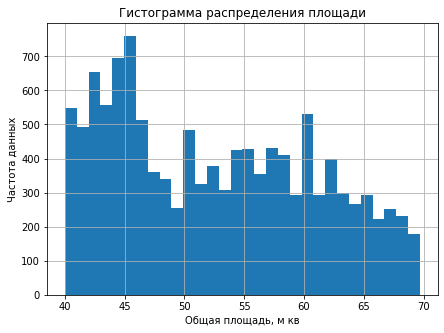

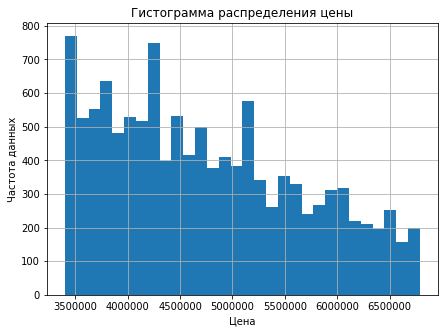

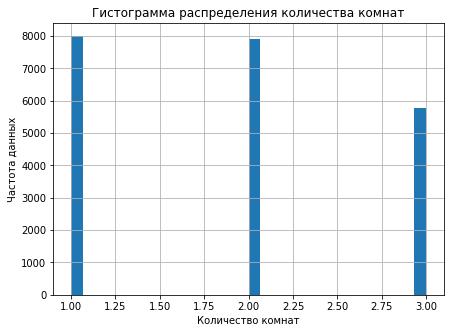

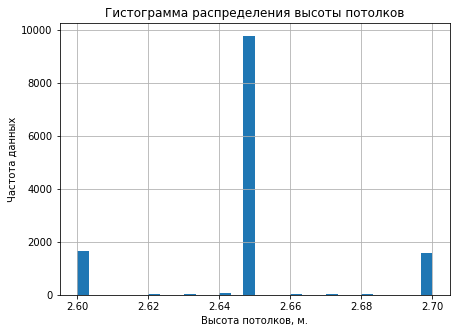

In [49]:
import matplotlib.pyplot as plt 
table_title = {'total_area':'Гистограмма распределения площади','last_price':'Гистограмма распределения цены','rooms':'Гистограмма распределения количества комнат','ceiling_height':'Гистограмма распределения высоты потолков'}
table_name = {'total_area':'Общая площадь, м кв','last_price':'Цена','rooms':'Количество комнат','ceiling_height':'Высота потолков, м.'}
for i in table_name:                                  # В цикле перебираем все столбцы, для которых требуется посторить гистограмму
    q1 = data[i].quantile(0.25)                 
    q3 = data[i].quantile(0.75)    
    data[i].plot(kind = 'hist', bins = 30, range = (q1,q3),grid=True, figsize = (7,5)) # Применяем метод построения для столбцов
    plt.ylabel('Частота данных')
    plt.xlabel(table_name[i])
    plt.title(table_title[i])
    plt.show()

#### Вывод
1. Большинство продаваемых квартир имеют площадь около 45 м кв  
2. Самый большой сегмент - квартиры от 3,5 млн до 4,25 млн. Далее чем выше цена, тем меньше объявлений меньше
3. Однушки и двушки преобладают на рынке, трехкомнатных на четверть меньше, а четырехкомнатные совсем редкость
4. Высота потолков 2,65 м - самая распространенная, все остальные встречаются очень редко.

<a name='session7'></a>
#### Изучение времени продажи квартиры

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

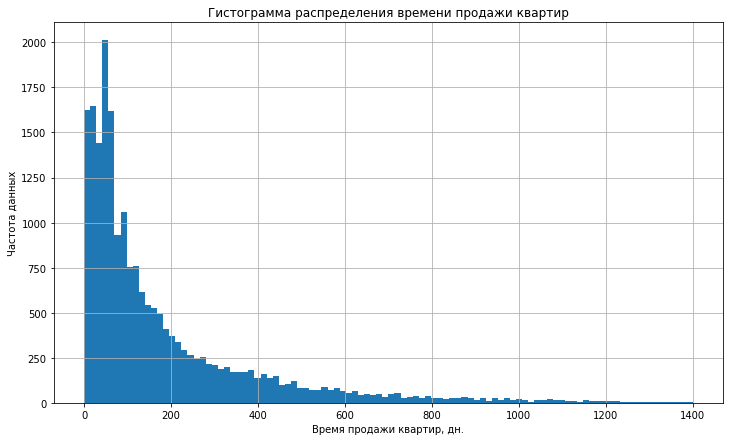

In [32]:
data['days_exposition'].plot(kind='hist', bins = 100,grid = True, range=(0,1400),figsize=(12,7))
plt.title('Гистограмма распределения времени продажи квартир')
plt.xlabel('Время продажи квартир, дн.')
plt.ylabel('Частота данных')
last_price_median = data['days_exposition'].median()
last_price_mean = data['days_exposition'].mean()
data['days_exposition'].describe()

#### Вывод
 Медианное значение того, сколько объявление висит - 95 дней, среднее 180  
 Первый кварниль равен 45 дням, если объявление снято бфстрее, то считаем, что продажа прошла быстро.  
 Третий квартиль равен 231 дню, если объясление висело дольше, то считаем, что продажа долгая.

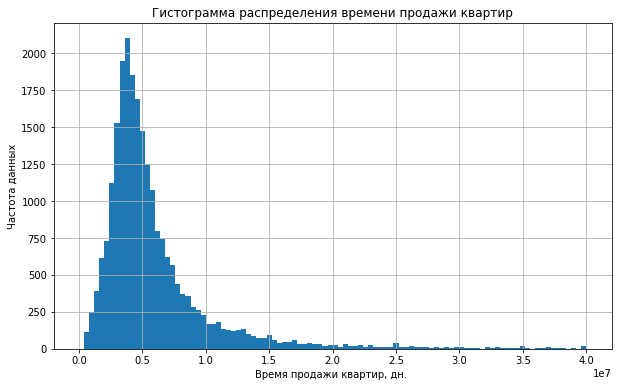

In [11]:
# код ревьювера
data['last_price'].plot(kind='hist', bins = 100,grid = True, range = (0,0.4e8),title = 'last_price', figsize=(10,6))
plt.title('Гистограмма распределения времени продажи квартир')
plt.ylabel('Частота данных')
plt.xlabel('Время продажи квартир, дн. ')
plt.show()

<a name='session8'></a>
#### Убирем редкие значения

In [12]:
q95 = data['days_exposition'].quantile(0.95) # 5% объявлений, которые висят дольше всех. Объявления висящие больше 647 дней, это очень долго
q05 = data['days_exposition'].quantile(0.05) # 5% объявлений, которые висят   меньше всех. Объявления висящие менее 9 дней, очень быстро
#print(q95)
#print(q05)
good_data = data.query('days_exposition < 647 and days_exposition > 9') # отфильтровали выбросы по столбцу days_exposition и записали результат в новую таблицу
#print(good_data.head())
good_data['days_exposition'].describe()


count    18246.000000
mean       151.664639
std        143.685937
min         10.000000
25%         45.000000
50%         96.000000
75%        210.000000
max        646.000000
Name: days_exposition, dtype: float64

#### Вывод
Медиана почти не изменилась, а среднее значение и отклонение изменились (уменьшились) на 16% и 45% соответственно

In [13]:
q95 = data['last_price'].quantile(0.95) # 5% объявлений, c самой высокой ценой. Объявления со стоимостью более 15.3 млн, это очень дорого
q05 = data['last_price'].quantile(0.05) # 5% объявлений, с самой низкой ценой. Объявления  со стоимостью менее 1.86 млн, это дешево
#print(q95)
#print(q05)
good_data = data.query('last_price < 15300000.0 and last_price > 1860000.0') # отфильтровали выбросы по столбцу last_price и записали результат в новую таблицу
#print(good_data.head())
print(good_data['last_price'].describe())
print(data['last_price'].describe())

count    2.120200e+04
mean     5.376430e+06
std      2.641304e+06
min      1.870000e+06
25%      3.550000e+06
50%      4.646500e+06
75%      6.490000e+06
max      1.527600e+07
Name: last_price, dtype: float64
count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64


#### Вываод
Медиана практически не изменилась, а среднее уменьшилось на 18%  
Стандартное отклонение выросло в 2,6 раз!

In [14]:
q95 = data['total_area'].quantile(0.95) # 5% Квартир с площадью более 116 м кв
q05 = data['total_area'].quantile(0.05) # 5% Кварир с площадью менее 31 м кв
#print(q95)
#print(q05)
good_data = data.query('total_area < 116.0 and total_area > 31.0') # отфильтровали выбросы по столбцу total_area и записали результат в новую таблицу
print(good_data['total_area'].describe())
print(data['total_area'].describe())

count    20902.000000
mean        56.264236
std         18.872699
min         31.090000
25%         41.800000
50%         52.100000
75%         67.000000
max        115.900000
Name: total_area, dtype: float64
count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


#### Вывод
Медиана и среднее слабо изменились, а std уменьшилось почти в 2 раза

In [15]:
q95 = data['rooms'].quantile(0.95) 
q05 = data['rooms'].quantile(0.05) 
print(q95)
print(q05)

4.0
1.0


#### Вывод
Слишком мало значений количества комнат, чтобы убирать их

In [16]:
q95 = data['ceiling_height'].quantile(0.95) # 5% Квартир с потолками более 3,13 метров
q05 = data['ceiling_height'].quantile(0.05) # 5% Кварир с потолками менее 2,5
#print(q95)
#print(q05)
good_data = data.query('ceiling_height < 3.13 and ceiling_height > 2.5') # отфильтровали выбросы по столбцу ceiling_height и записали результат в новую таблицу
print(good_data['ceiling_height'].describe())
print(data['ceiling_height'].describe())

count    18788.00000
mean         2.68966
std          0.11614
min          2.51000
25%          2.65000
50%          2.65000
75%          2.70000
max          3.12000
Name: ceiling_height, dtype: float64
count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


#### Вывод
Как и у предыдущих параметров - медиана неизменна. Среднее также слабо изменилось,  
а вот std уменьшилось в 9 раз!

<a name='session9'></a>
#### Факторы влияния на цену

In [17]:
print(good_data['last_price'].corr(good_data['total_area'])) # умеренно сильная положительная зависимость цены от площади
print(good_data['last_price'].corr(good_data['rooms'])) # умеренно слабая положительная зависимость цены от количества комнат
print(good_data['last_price'].corr(good_data['cityCenters_nearest'])) # слабая отрицательная зависимость от удаленности от центра

0.6268668000383362
0.3513974019202288
-0.18947822361061256


In [18]:
# так как сравнить можно только числовые типы, создадим стольец, где первому этажу будет соответствовать 1,
#последнему 3, остальным 2
def floor_number_group(row):
        if row == 'первый':
            return 1
        if row == 'последний':
            return 3
        else:
            return 2
good_data['floor_number_group'] = good_data['floor_category'].apply(floor_number_group)

print(good_data['floor_number_group'].corr(good_data['last_price'])) # зависимости у цены от категории этажа почти нет

0.05985607604144015


In [19]:
print(good_data['exposition_year'].corr(good_data['last_price'])) # Зависимости почти нет
print(good_data['exposition_month'].corr(good_data['last_price']))  # Зависимости почти нет совсем
print(good_data['exposition_weekday'].corr(good_data['last_price'])) # Зависимости почти нет совсем

-0.03481141977671283
0.006254177559795983
0.009289416038245851


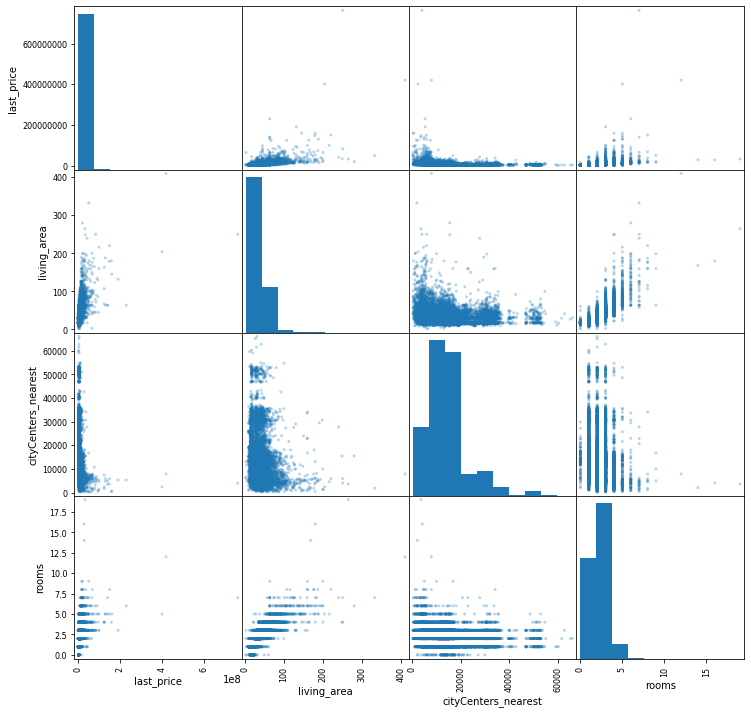

In [51]:
good_data_scat=good_data[['last_price','living_area','cityCenters_nearest','rooms']]
pd.plotting.scatter_matrix(good_data_scat, figsize=(12, 12),alpha=0.3)
plt.show()

#### Вывод
Из матрицы видно, что цена прямо зависит от площади, количества комнат и близости к центру

<a name='session10'></a>
#### Анализ 10 населённых пунктов с наибольшим числом объявлений

In [21]:
m_locality_name = good_data.groupby('locality_name')['total_area'].count().sort_values(ascending=False).head(10)
# делаем срез good data по m_locality_name
top_good_data = good_data.query('locality_name in @m_locality_name.index')
print(top_good_data.groupby('locality_name')['total_area'].mean()) # НАшли среднюю площадь

locality_name
Всеволожск           56.402562
Выборг               56.108525
Гатчина              52.062414
Колпино              54.169558
Пушкин               63.484234
Санкт-Петербург      63.392512
деревня Кудрово      46.520638
посёлок Мурино       44.148902
посёлок Парголово    51.819551
посёлок Шушары       54.573985
Name: total_area, dtype: float64


In [22]:
top_good_data_group = top_good_data.groupby('locality_name')['last_price'].mean().reset_index()

print('Самый дорог населенный пункт',top_good_data_group[top_good_data_group['last_price']== top_good_data_group['last_price'].max()])
print()
print('Сымый дешевый населенный пункт',top_good_data_group[top_good_data_group['last_price']== top_good_data_group['last_price'].min()])



Самый дорог населенный пункт      locality_name    last_price
5  Санкт-Петербург  7.738652e+06

Сымый дешевый населенный пункт   locality_name    last_price
1        Выборг  3.235503e+06


<a name='session11'></a>
#### Анализ квартир СПБ

Text(0, 0.5, 'Цена, млн руб.')

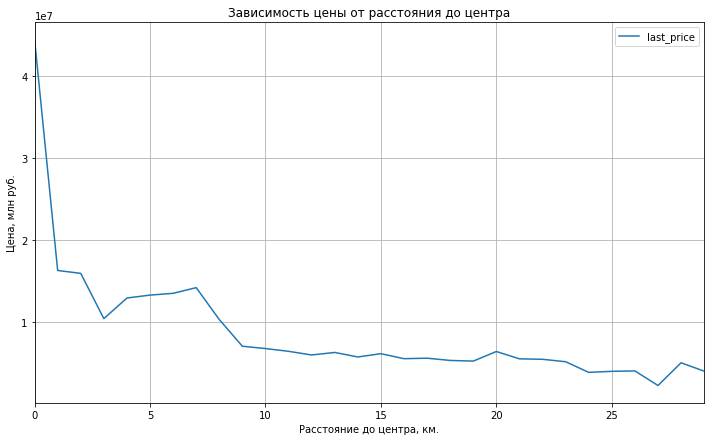

In [35]:
good_data_spb = good_data.query('locality_name == "Санкт-Петербург"') # Серз, оставляем только объявления по Питеру
good_data_spb['cityCenters_nearest_km'] = round(good_data_spb['cityCenters_nearest']/1000) # Переводим расстояние в км и округляем
good_data_spb.pivot_table(index = 'cityCenters_nearest_km', values = 'last_price').plot(kind = 'line',grid=True, figsize=(12,7), title = 'Зависимость цены от расстояния до центра')
# в радиусе 3 КМ сильный скачок в цене, тут и начинается центральная зона
plt.xlabel('Расстояние до центра, км.')
plt.ylabel('Цена, млн руб.')


<a name='session12'></a>
#### Сегментация квартир в центре

In [24]:
good_data_spb_center = good_data_spb.query('cityCenters_nearest_km <= 3') # Срез, в который входят только объявления по центру
# Изучим данные по площади, цене, числу комнат и высоте потолков
print(good_data_spb_center['total_area'].describe())
print(good_data_spb_center['last_price'].describe())
print(good_data_spb_center['rooms'].describe())
print(good_data_spb_center['ceiling_height'].describe())

count    522.000000
mean      92.405345
std       51.231287
min       12.000000
25%       61.125000
50%       81.100000
75%      110.750000
max      517.000000
Name: total_area, dtype: float64
count    5.220000e+02
mean     1.445050e+07
std      2.395960e+07
min      2.100000e+06
25%      6.800000e+06
50%      9.000000e+06
75%      1.390000e+07
max      4.013000e+08
Name: last_price, dtype: float64
count    522.000000
mean       3.028736
std        1.424066
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       14.000000
Name: rooms, dtype: float64
count    522.000000
mean       2.783487
std        0.167611
min        2.550000
25%        2.650000
50%        2.650000
75%        3.000000
max        3.120000
Name: ceiling_height, dtype: float64


In [25]:
print('Данные по центру')
print(good_data_spb_center['last_price'].corr(good_data_spb_center['total_area'])) 
print(good_data_spb_center['last_price'].corr(good_data_spb_center['rooms'])) 
print(good_data_spb_center['last_price'].corr(good_data_spb_center['cityCenters_nearest']))
print('Данные по всему городу')
print(good_data_spb['last_price'].corr(good_data_spb['total_area'])) 
print(good_data_spb['last_price'].corr(good_data_spb['rooms'])) 
print(good_data_spb['last_price'].corr(good_data_spb['cityCenters_nearest']))

# В центральном округе цена меньше зависит от площади и количества комна, чем во всем городе

Данные по центру
0.6144614507639586
0.25834550860792405
-0.15489798040008124
Данные по всему городу
0.6326259275668485
0.3601134143836774
-0.23185493163135665


<a name='session6'></a>
### Шаг 5. Общий вывод

В большей степени продаются 1 и 2-ух комнатные квартиры с небольшой площадью
Цена квартир очень зависит от площади и числа комнат - это две самые главные характеристики.
Близость к центральному округа не сильно влияет на цену, но нахождение в его приделах (около 3 км) цена значительно возрастает.